In [58]:
from pathlib import Path
import matplotlib.pyplot as plt
import lightning as L
import torch
import torch.nn as nn
from lit_llama import model
import random
from lit_llama import LLaMA, Tokenizer
from lit_llama.utils import EmptyInitOnDevice, lazy_load, llama_model_lookup

from datasets import load_dataset
from transformers import AutoTokenizer


In [2]:
fabric = L.Fabric(devices=1)
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")
tokenizer = Tokenizer(tokenizer_path)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)


Found cached dataset squad (/home/andrew/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


'The Beyoncé Experience'

In [4]:
import json
with open('datasets/alpaca_data_cleaned.json') as f:
    alpaca_json = json.load(f)

# Create tokenized j
alpaca_json_tokens = []

for item in squad['train']:
    alpaca_json_tokens.append(
        {
            'instruction': tokenizer.encode(item['context'], bos=True, eos=False, device=fabric.device),
            'input': tokenizer.encode(item['question'], bos=False, eos=False, device=fabric.device),
            'output':tokenizer.encode(item['answers']['text'][0], bos=False, eos=True, device=fabric.device)
        }
    )

In [62]:
def get_single_example():
    index = random.sample(range(len(alpaca_json_tokens)), k=1)[0]
    # IST
    IST = IST_generator(LLamaModel(alpaca_json_tokens[index]['instruction'].unsqueeze(0).to(fabric.device))[1])[:,-1,:]

    # Question
    question = LLamaModel.transformer.wte(alpaca_json_tokens[index]['input'].unsqueeze(0).to(fabric.device)).squeeze()

    # Answer fragment
    answer_len = alpaca_json_tokens[index]['output'].size(0)
    trunc_len = random.randint(0,answer_len-1)
    #print(answer_len)
    #print(trunc_len)

    truncated_answer = alpaca_json_tokens[index]['output'][:trunc_len]
    truncated_answer = LLamaModel.transformer.wte(truncated_answer)
    
    target_tokens = torch.cat([alpaca_json_tokens[index]['input'], alpaca_json_tokens[index]['output'][:trunc_len+1]])
    #print(tokenizer.decode(target_tokens))

    llama_input = torch.cat([IST,question,truncated_answer])
    return llama_input.unsqueeze(0), target_tokens.type(torch.LongTensor).unsqueeze(0)
    
    

In [60]:
losses = []

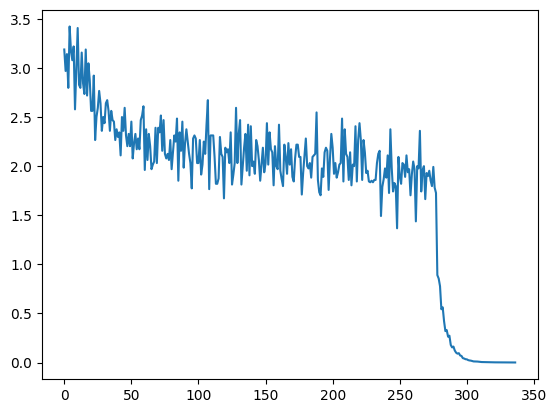

In [59]:
plt.plot(losses)

In [61]:
IST_generator = model.Block(LLaMA_config)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-4)
IST_generator = IST_generator.to(fabric.device)

In [64]:
loss_fn = nn.CrossEntropyLoss()
for param in LLamaModel.parameters():
    param.requires_grad=False

for epoch in range(1000):
    #batch = get_batch(LLamaModel.transformer.wte, batch_size=1)
    
    batch_loss = 0

    for i in range(32):
        input, target = get_single_example()
        llama_output = LLamaModel.forward_embeddings(input.type(torch.bfloat16))[0]
        loss = loss_fn(llama_output.squeeze().to(fabric.device), target.squeeze().to(fabric.device))
        batch_loss += loss
    batch_loss /= 32

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    #print(IST_generator.mlp.c_fc1.weight)
    losses.append(batch_loss.item())
    print(f'epoch {epoch}, loss={batch_loss.item()}')

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 23.68 GiB total capacity; 22.74 GiB already allocated; 57.50 MiB free; 22.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
checkpoint_path: Path = Path("checkpoints/lit-llama/7B/lit-llama.pth")
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")


def load_LLaMA(checkpoint_path):
    with lazy_load(checkpoint_path) as checkpoint:
        name = llama_model_lookup(checkpoint)

        with EmptyInitOnDevice(
                device=fabric.device, dtype=dtype, quantization_mode=None # We won't quantize the weights
        ):
            model = LLaMA.from_name(name)

        model.load_state_dict(checkpoint)
    return model

In [11]:

dtype = torch.bfloat16 if fabric.device.type == "cuda" and torch.cuda.is_bf16_supported() else torch.float32

LLaMA_config = model.LLaMAConfig.from_name('7B')
print('Loading models...')
# Load the LLaMa model and the IST generator (also a LLaMA model)
LLamaModel = load_LLaMA(checkpoint_path).to(fabric.device)
#LLamaModel = LLaMA(LLaMA_config).to(fabric.device)
print('Finished loading the first model')
print('Finished loading models')
tokenizer = Tokenizer(tokenizer_path)

IST_schemes = ['vanilla', 'last 4', '2nd to last', 'all layers']
scheme_losses = {}

IST_generator = model.Block(LLaMA_config)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-4)
IST_generator = IST_generator.to(fabric.device)

Loading models...
Finished loading the first model
Finished loading models


In [12]:
for param in LLamaModel.parameters():
    param.requires_grad=False

In [27]:
def get_IST(string):
    tokens = tokenizer.encode(string).unsqueeze(0).type(torch.LongTensor).to(fabric.device)
    x = LLamaModel(tokens)[1]
    x = IST_generator(x)
    return x[:,-1,:]

In [54]:
def generate(model, tokenizer, prompt, IST=None, max_new_tokens=200):
  
    
    generated = ''
    tokenized_input = tokenizer.encode(prompt).to(fabric.device)
    with torch.no_grad():

        for _ in range(max_new_tokens):
            last_logits = model(tokenized_input.unsqueeze(0), IST.type(torch.bfloat16))[0][:,-1,:]
            new_token = torch.argmax(last_logits, dim=1)
            if(new_token == 2): #eos
                break
            generated += tokenizer.decode(new_token)
            tokenized_input = torch.cat([tokenized_input, new_token])

    print(tokenizer.decode(tokenized_input))
    return tokenized_input

In [55]:
context = squad['train'][0]['context']
question = squad['train'][0]['question']

In [57]:
out = generate(LLamaModel, tokenizer, question, IST=get_IST(context))

What did Beyonce call her first concert tour? The Beyoncé Experience


In [53]:
squad['train'][0]

{'id': '56d65c671c850414009470bd',
 'title': '2008_Sichuan_earthquake',
 'context': 'Besides parents, Liu Shaokun (刘绍坤), a Sichuan school teacher, was detained on June 25, 2008 for "disseminating rumors and destroying social order" about the Sichuan earthquake. Liu’s family was later told that he was being investigated on suspicion of the crime of inciting subversion. Liu had travelled to the Shifang, taken photos of collapsed school buildings, and put them online. He had also expressed his anger at “the shoddy tofu-dregs buildings” (豆腐渣工程) in a media interview. He was ordered to serve one year of re-education through labor (RTL). According to the organization Human Rights in China, Liu has been released to serve his RTL sentence outside of the labor camp.',
 'question': 'What was his assigned punishment ?',
 'answers': {'text': ['one year of re-education'], 'answer_start': [508]}}